# Homework 7: Optimizing clustering algorithms

One way to quantitatively measure the performance of a clustering method is to compare the predicted labels to the ground-truth labels (given that those are available). Here we will use the **normalized mutual information** $$NMI(Y,C)=\frac{2*I(Y,C)}{H(Y)+H(C)},$$ where $I$ is the mutual information $I(Y,C)$ between predicted and true cluster labels, and $H(Y)$ is the entropy of a cluster. (see https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html for more discussion on the subject and other possible metrics) to perform such comparison. As we will see, when doing clustering, there is usually no free lunch: if one chooses the wrong set of parameters (which can be quite sensitive), the clustering algorithm will likely fail or return a trivial answer (for instance all points assigned to the same cluster).  

As a dataset, let's consider a 2D Gaussian mixture of 15 clusters:

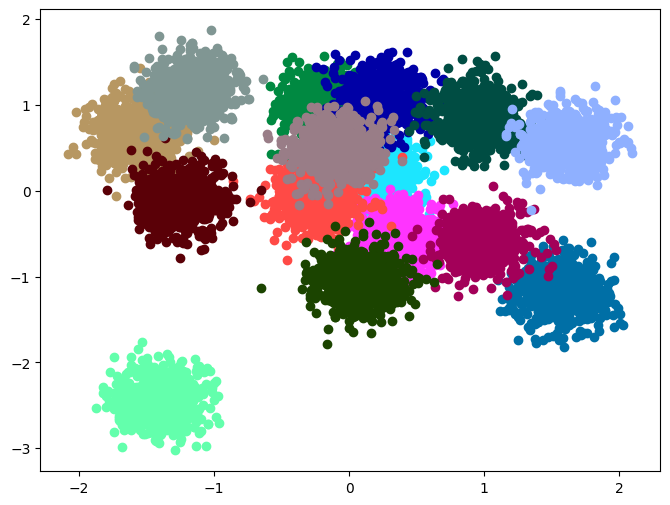

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import normalized_mutual_info_score

n_samples=10000
n_components = 15

np.random.seed(0)

X, y = make_blobs(n_samples=n_samples, centers=n_components) # Generating random gaussian mixture
X = StandardScaler().fit_transform(X)

cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

def plot_clustering(X,y):
    plt.figure(figsize=(8,6))
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        plt.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)])
    plt.show()

plot_clustering(X,y)
print(np.unique(y))

1. Try to write a function that returns the normalized mutual information between two sets of cluster assignments. It is useful to first define a helper functions that for each of the 15 clusters, produces a list of the indices of the points that belong to a given cluster. One can use a python OrderedDict() for that but does not have to. From such a list it is easy to compute the entropy $H$, the mutual information $I$ and finally the normalized MI. For efficient calculation of MI one can use python's *set.intersection()* method.

   If you get stuck, you can fall back onto sklearn's version at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html, but just using it will not be as insightful as programming it yourself.

In [94]:
xtest = np.array([0,1,1,1,1,1])
ytest = np.array([0,1,1,0,1,0])

def joint_prob(x, y):
    joint_prob_matrix = np.zeros((len(np.unique(x)), len(np.unique(y))))
    for i in range(len(x)):
        joint_prob_matrix[x[i], y[i]] += 1
        
    joint_prob_matrix /= len(x)
    return joint_prob_matrix
    

def entropy(prob_x):
    return -np.sum(prob_x * np.log2(prob_x))
    

def normalized_mutual_info(x,y):
    
    joint_prob_matrix = joint_prob(x, y)
    prob_x = np.sum(joint_prob_matrix, axis = 1)
    prob_y = np.sum(joint_prob_matrix, axis = 0)
    
    entropy_x = entropy(prob_x)
    entropy_y = entropy(prob_y)
    
    mutual_info = 0
    for i in range(len(np.unique(x))):
        for j in range(len(np.unique(y))):
            if joint_prob_matrix[i,j] > 0:
                mutual_info += joint_prob_matrix[i,j] * np.log2(joint_prob_matrix[i,j] / (marg_prob_x[i] * marg_prob_y[j]))
    
    return 2 *  mutual_info / (entropy_x + entropy_y)

# test
np.round(normalized_mutual_info(xtest,ytest),10) == np.round(normalized_mutual_info_score(xtest, ytest),10)

True

2. Using your new NMI function, find the number of clusters for which the K-means algorithm yields the highest NMI. Then use the routine *plot_clustering* from above to visualize the clustering for this optimal choice of clusters.

   While computing the predictions of the different models, also record the attribute inertia_ from the Kmeans algorithm. What does it tell us?

    **it measures the sum of squares within a cluster, which tells us the distance between the center of a cluster and all points classified within it. the value given is the sum of all the sums of squares given by each cluster**

   Make a graph of this parameter, sometimes called 'distortion', versus number of clusters.

number of clusters yielding highest NMI: 14


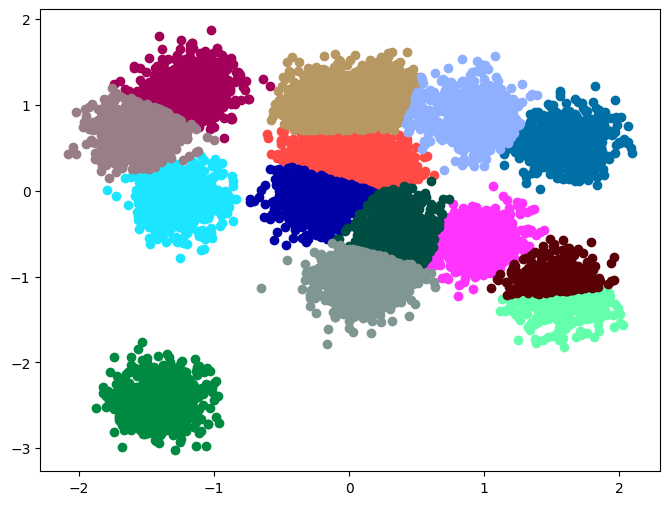

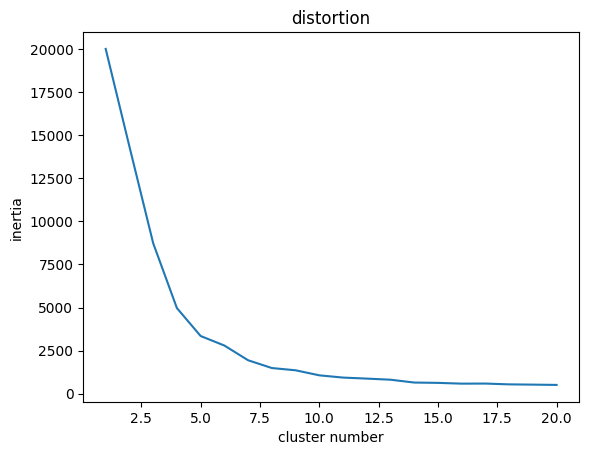

In [128]:
from sklearn.cluster import KMeans

cluster_num = np.arange(1,21)
inertias = []

nmi = []

for i in cluster_num:
    model = KMeans(n_clusters = i)
    model.fit(X)
    ypred = model.predict(X)
    inertias.append(model.inertia_)
    nmi.append(normalized_mutual_info_score(y,ypred))

print('number of clusters yielding highest NMI: {}'.format(cluster_num[np.argmax(nmi)]))

model = KMeans(n_clusters = cluster_num[np.argmax(nmi)])
model.fit(X)
ypred = model.predict(X)
plot_clustering(X,ypred)
plt.show()

plt.plot(cluster_num, inertias)
plt.xlabel('cluster number')
plt.ylabel('inertia')
plt.title('distortion')
plt.show()

3. Now sweep over the main parameters of DBSCAN and compute the normalized mutual information for every assignment found. DBSCAN does a great job of clustering when the parameters are well chosen. `minPts` is responsible for determining what an outsider is (i.e. if a point has less than `minPts` in its epsilon neighborhood, it is not a core-point). `eps` tunes the size of the neighborhood of each point which is just a circle of radius `eps`.

   Try searching in
   eps_range = [0.01,0.1,0.5,1.0,10.], 
   min_sample_range = [5,20,40,100] and plot again the cluster assignment for the optimal parameters found.


In [120]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import normalized_mutual_info_score
import pandas as pd

eps_range = [0.01, 0.1, 0.5, 1.0, 10.0]
min_samples_range = [5,20, 40, 100]
nmi = np.zeros((len(eps_range), len(min_samples_range)))

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_samples_range):
        ypred = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)
        #ypred = db.predict(X)
        nmi[i,j] = normalized_mutual_info_score(y,ypred)

nmi

array([[0.02768379, 0.        , 0.        , 0.        ],
       [0.16317957, 0.4751556 , 0.63462377, 0.27535418],
       [0.16594131, 0.16594131, 0.16594131, 0.16594131],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

(1, 2)
best eps: 0.1 
 best minimum sample number: 40


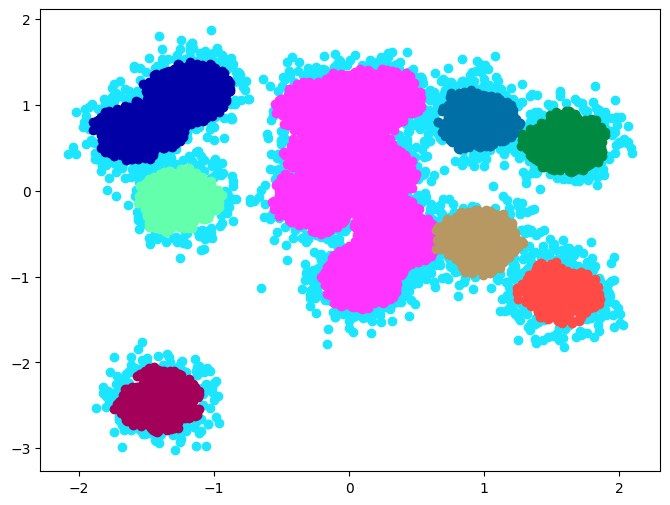

In [122]:
index = np.unravel_index(np.argmax(nmi, axis=None), nmi.shape)
print(index)
best_eps = eps_range[index[0]]
best_sample_number = min_samples_range[index[1]]

print('best eps: {}'.format(best_eps), '\n', 'best minimum sample number: {}'.format(best_sample_number))

ypred = DBSCAN(eps=best_eps, min_samples=best_sample_number).fit_predict(X)
plot_clustering(X,ypred)